In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product i.csv', parse_dates=['Month-Year'])


In [3]:
sales_i= df.drop(['Product Name','Product Category','Month','Year','Month No.'],axis=1)

In [4]:
sales_i = sales_i.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_i.head(5)

,ds,y,Market Size,Marketing Expense
0,2019-01-01,50833,600282,1024825
1,2019-02-01,65670,775491,1323949
2,2019-03-01,89667,1058869,1807743
3,2019-04-01,60960,719871,1228992
4,2019-05-01,43410,512625,875173


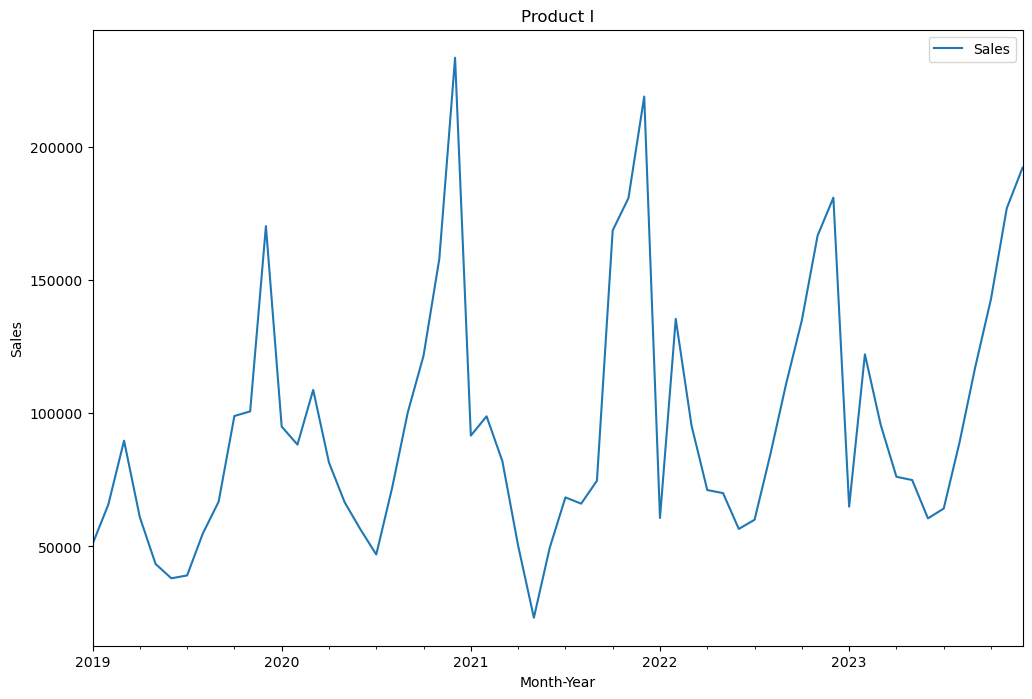

In [5]:
ax = sales_i.set_index('ds')['y'].plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product I')
plt.legend(['Sales'])
plt.show()


In [6]:
train= sales_i[:54]
test=sales_i[54:]

In [7]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}


# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.add_regressor('Market Size')
    m.add_regressor('Marketing Expense')
    m.fit(train)
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '180 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

00:47:14 - cmdstanpy - INFO - Chain [1] start processing
00:47:15 - cmdstanpy - INFO - Chain [1] done processing
00:47:17 - cmdstanpy - INFO - Chain [1] start processing
00:47:18 - cmdstanpy - INFO - Chain [1] done processing
00:47:21 - cmdstanpy - INFO - Chain [1] start processing
00:47:21 - cmdstanpy - INFO - Chain [1] done processing
00:47:23 - cmdstanpy - INFO - Chain [1] start processing
00:47:23 - cmdstanpy - INFO - Chain [1] done processing
00:47:27 - cmdstanpy - INFO - Chain [1] start processing
00:47:27 - cmdstanpy - INFO - Chain [1] done processing
00:47:30 - cmdstanpy - INFO - Chain [1] start processing
00:47:30 - cmdstanpy - INFO - Chain [1] done processing
00:47:33 - cmdstanpy - INFO - Chain [1] start processing
00:47:34 - cmdstanpy - INFO - Chain [1] done processing
00:47:36 - cmdstanpy - INFO - Chain [1] start processing
00:47:36 - cmdstanpy - INFO - Chain [1] done processing
00:47:38 - cmdstanpy - INFO - Chain [1] start processing
00:47:39 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

            rmse  
0   15338.495543  
1   18781.160807  
2   19454.224832  
3   17659.822387  
4   21397.327416  
..       

In [8]:
tuning_results.sort_values('rmse',ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse
48,0.300,0.01,additive,14523.537057
36,0.200,0.01,additive,14743.043600
24,0.100,0.01,additive,14999.149409
12,0.010,0.01,additive,15217.933627
0,0.001,0.01,additive,15338.495543
...,...,...,...,...
71,0.500,10.00,multiplicative,25094.367701
50,0.300,0.10,additive,25411.462902
63,0.500,0.10,multiplicative,28533.726255
70,0.500,10.00,additive,34843.387550


In [9]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive'}


In [10]:
# Create a Prophet model
#model = Prophet(changepoint_prior_scale=0.0100, seasonality_prior_scale=4.006, interval_width=0.95)
model = Prophet(changepoint_prior_scale=0.300, seasonality_prior_scale=0.01, seasonality_mode= 'additive', interval_width=0.95)
model.add_regressor('Market Size')
model.add_regressor('Marketing Expense')

In [11]:
model.fit(train)

01:02:17 - cmdstanpy - INFO - Chain [1] start processing
01:02:17 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
len(test)

6

In [13]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [14]:
future_dates['Market Size'] = sales_i['Market Size']
future_dates['Marketing Expense'] = sales_i['Marketing Expense']

In [15]:
future_dates

,ds,Market Size,Marketing Expense
0,2019-01-01,600282,1024825
1,2019-02-01,775491,1323949
2,2019-03-01,1058869,1807743
3,2019-04-01,719871,1228992
4,2019-05-01,512625,875173
5,2019-06-01,449010,766568
6,2019-07-01,461693,788220
7,2019-08-01,647955,1106214
8,2019-09-01,788516,1346186
9,2019-10-01,1188838,2029631


In [16]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [17]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

In [18]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
54,2023-07-01,69944.387771,39487.470683,99168.837684
55,2023-08-01,88468.587758,59542.052729,118267.132167
56,2023-09-01,109240.640509,79307.404906,140962.326214
57,2023-10-01,143143.954341,112636.263844,172157.935253
58,2023-11-01,143393.999813,112471.440218,172794.162517
59,2023-12-01,166025.388639,135463.369321,196295.046753


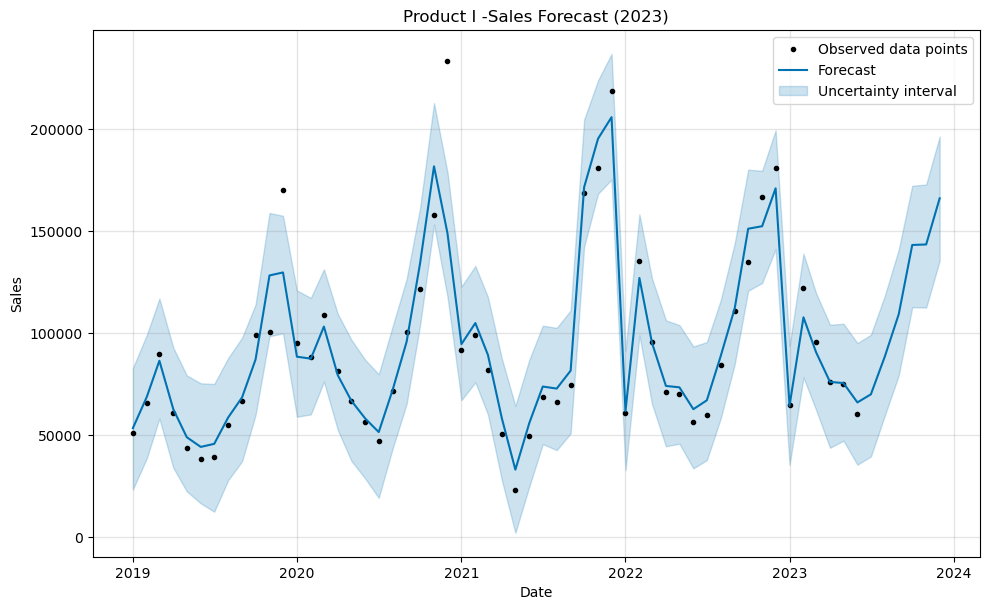

In [19]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product I -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

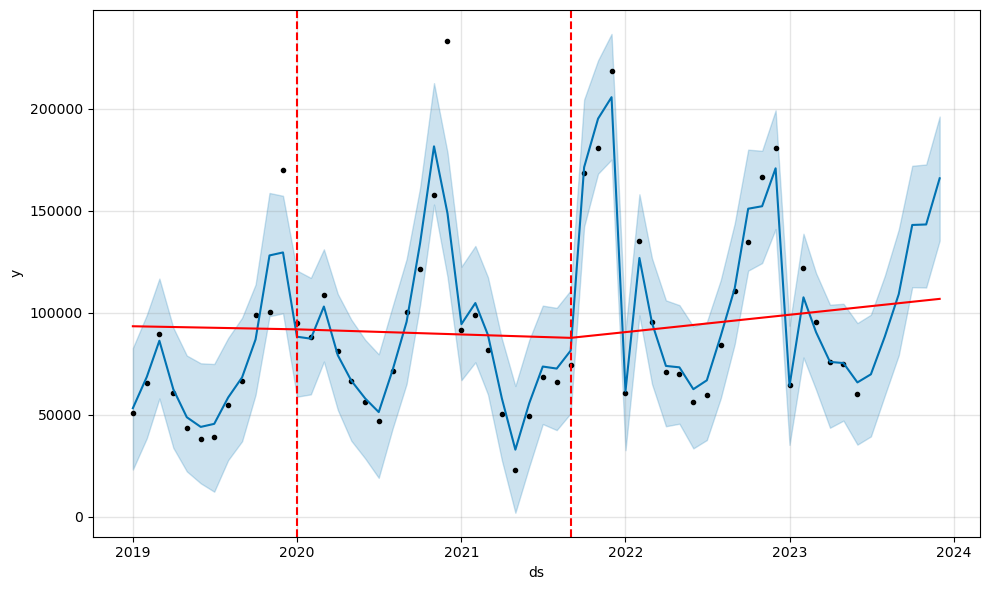

In [20]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

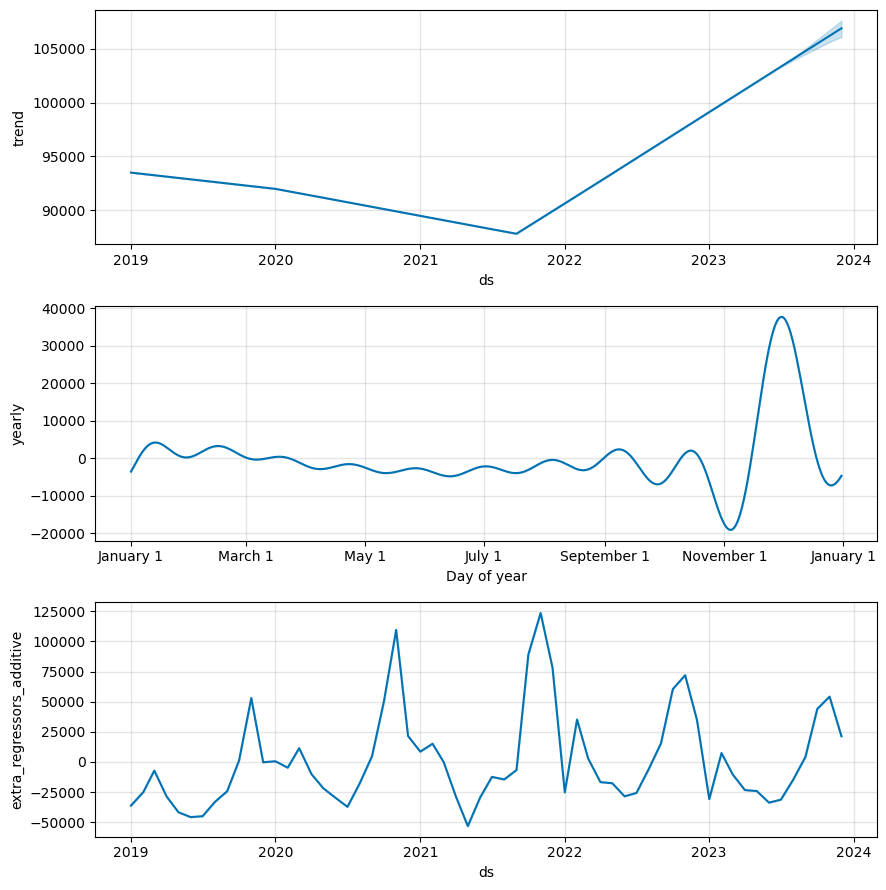

In [21]:
fig2 = model.plot_components(forecast)

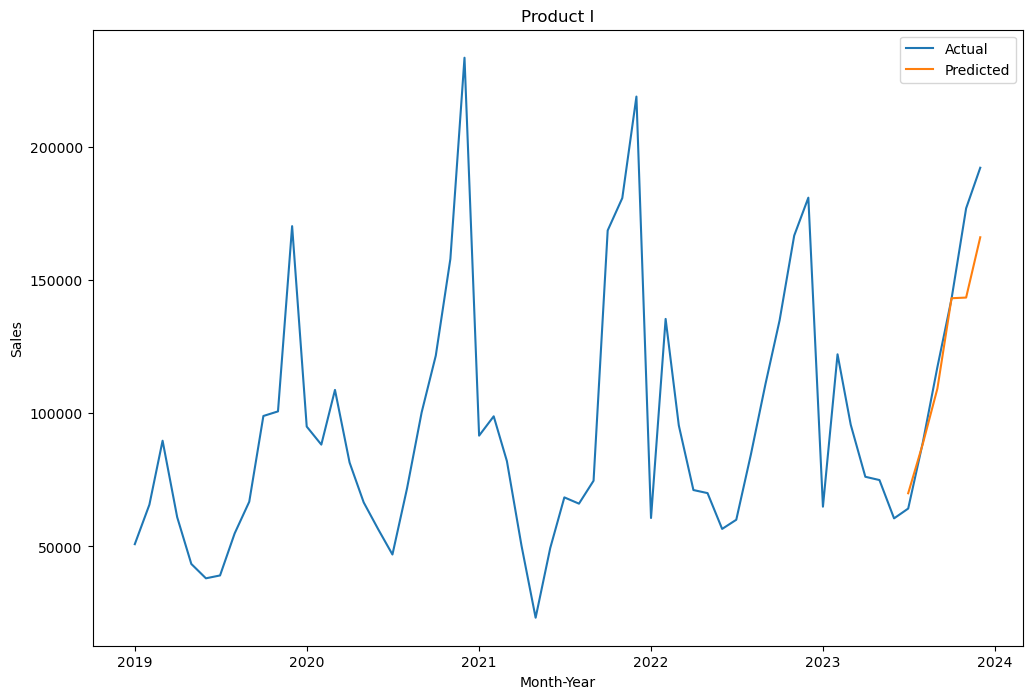

In [22]:
# Reset index of sales_b DataFrame
sales_i_reset_index = sales_i.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_i_reset_index['ds'], sales_i_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product I')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [23]:
#model evaluation

In [24]:
pred=forecasted_df['yhat']
test_df=test['y']

In [25]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 12357.788
MAPE - FB PROPHET: 0.082
MSE - FB PROPHET: 316945921.616
RMSE - FB PROPHET: 17802.975


In [26]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='180 days', parallel="processes")

In [27]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,24 days,3.362264e+07,5798.503372,5061.578071,0.076085,0.076085,0.073284,1.0
1,25 days,3.702309e+06,1924.138457,1894.134064,0.031366,0.031366,0.031546,1.0
2,29 days,1.046551e+07,3235.044658,2929.047548,0.046107,0.046107,0.047078,1.0
3,51 days,4.664082e+07,6829.408372,6474.719976,0.098609,0.098609,0.095722,1.0
4,55 days,2.215515e+08,14884.607714,13919.496287,0.136347,0.136347,0.137732,1.0
5,56 days,1.892541e+08,13756.966770,11190.975412,0.089765,0.089765,0.095536,1.0
6,60 days,2.487542e+08,15771.944733,12632.787067,0.109286,0.109286,0.118634,1.0
7,82 days,2.720055e+08,16492.587754,14802.054717,0.140833,0.140833,0.147397,1.0
8,83 days,6.284735e+07,7927.631937,7918.054910,0.093973,0.093973,0.093534,1.0
9,87 days,7.078491e+07,8413.376673,8412.720089,0.081927,0.081927,0.085441,1.0


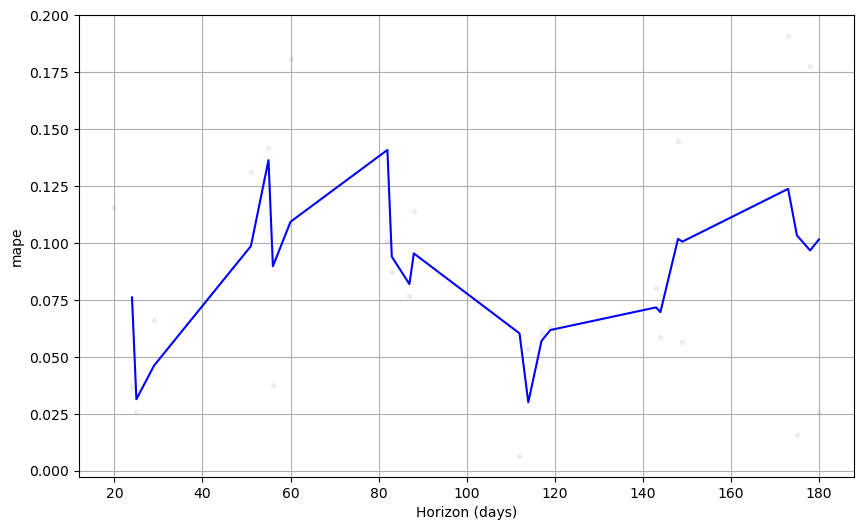

In [28]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [29]:
test_df

54     64200
55     88953
56    117297
57    142882
58    176896
59    192123
Name: y, dtype: int64

In [30]:
pred

54     69944.387771
55     88468.587758
56    109240.640509
57    143143.954341
58    143393.999813
59    166025.388639
Name: yhat, dtype: float64